# Experimento 2: _One Vs All_

Realizando classificação com KNN usando para treino os arquivos `chbNN_com_dwt.csv` onde `NN` pertence ao `chb_set`, com exceção do que será usado para teste.

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Carregando intervalo de chb
file_range = [
    '01', '02', '03', '04', '05', '07', '08',
    '10', '11', '12', '13', '14', '15', '16',
    '17', '18', '19', '21', '22', '23', '24'
]

def dataframe_from_chb(chb_number:str):
    df = pd.read_csv(f'./chb{chb_number}/chb{chb_number}_com_dwt.csv')
    df['chb'] = chb_number
    return df

chb_df = pd.concat([dataframe_from_chb(file) for file in file_range], ignore_index=True)


some_6_channels = ['2', '3', '6', '7', '10', '14']
some_8_channels = some_6_channels + ['5', '11']

# Filtrando colunas do chb que são referentes aos canais em some_6_channels
columns_from_6_channels = [column for column in chb_df.columns if column.split('-')[-1] in some_6_channels]

# Filtrando colunas do chb que são referentes aos canais em some_8_channels
columns_from_8_channels = [column for column in chb_df.columns if column.split('-')[-1] in some_8_channels]

In [2]:
acc_df_list = []

proba_dict = {
    file:{
        channel:pd.DataFrame() for channel in ['all', '6ch', '8ch']
    } for file in file_range
}

for file in file_range:

    # Separando dados de treino e teste
    chb_copy_df = chb_df.copy()

    chb_train = chb_copy_df.query('chb != @file')
    chb_test = chb_copy_df.query('chb == @file')

    chb_train.pop('chb')
    chb_test.pop('chb')

    y_train = chb_train.pop('target').values
    y_test = chb_test.pop('target').values

    # Para 20 rodadas com todos os canais
    X_all = chb_train.values

    # Para 20 rodadas com os 6 canais
    X_6_channels = chb_train[columns_from_6_channels].values

    # Para 20 rodadas com os 8 canais
    X_8_channels = chb_train[columns_from_8_channels].values

    # Instanciando e treinando classificadores
    model_all = KNeighborsClassifier().fit(X_all, y_train)
    model_6_ch = KNeighborsClassifier().fit(X_6_channels, y_train)
    model_8_ch = KNeighborsClassifier().fit(X_8_channels, y_train)

    # gerando probabilidades
    proba_all = model_all.predict_proba(chb_test.values)
    proba_6ch = model_6_ch.predict_proba(chb_test[columns_from_6_channels].values)
    proba_8ch = model_8_ch.predict_proba(chb_test[columns_from_8_channels].values)

    # Salvando probabilidades em dicionário
    for channel, proba_arr in zip(['all', '6ch', '8ch'], [proba_all, proba_6ch, proba_8ch]):
        df = proba_dict[file][channel]
        for num, classification in enumerate(['negative', 'positive']):
            df[f'{classification} sample-negative proba'], df[f'{classification} sample-positive proba']\
                = np.array([proba for proba, target in zip(proba_arr, y_test) if target == num]).transpose()

    # Formando dataframe de acurácias
    acc_df = pd.DataFrame(data=[file], columns=['chb'], dtype=np.float64)
    acc_df['all channels'] = model_all.score(chb_test.values, y_test)
    acc_df['2_3_6_7_10_14 channels'] = model_6_ch.score(chb_test[columns_from_6_channels].values, y_test)
    acc_df['2_3_6_7_10_14_11_14 channels'] = model_8_ch.score(chb_test[columns_from_8_channels].values, y_test)

    acc_df_list.append(acc_df)

one_vs_all_df = pd.concat(acc_df_list, ignore_index=True).sort_values(by='chb')
one_vs_all_df.to_csv('./oneVSall.csv', index=False)

## Metricas

In [3]:
one_vs_all_df = pd.read_csv('./oneVSall.csv')
one_vs_all_df.style.background_gradient(cmap='Blues', subset=one_vs_all_df.columns[1:]).hide_index()

chb,all channels,2_3_6_7_10_14 channels,2_3_6_7_10_14_11_14 channels
1.000000,0.905093,0.870370,0.893519
2.000000,0.767857,0.863095,0.821429
3.000000,0.938776,0.905612,0.913265
4.000000,0.801075,0.768817,0.733871
5.000000,0.880000,0.898182,0.878182
7.000000,0.950000,0.943750,0.943750
8.000000,0.772527,0.719780,0.772527
10.000000,0.922018,0.880734,0.908257
11.000000,0.756250,0.836250,0.836250
12.000000,0.589286,0.608193,0.608193


In [4]:
one_vs_all_df.style.background_gradient(cmap='Blues', subset=one_vs_all_df.columns[1:], axis='columns').hide_index()

chb,all channels,2_3_6_7_10_14 channels,2_3_6_7_10_14_11_14 channels
1.000000,0.905093,0.870370,0.893519
2.000000,0.767857,0.863095,0.821429
3.000000,0.938776,0.905612,0.913265
4.000000,0.801075,0.768817,0.733871
5.000000,0.880000,0.898182,0.878182
7.000000,0.950000,0.943750,0.943750
8.000000,0.772527,0.719780,0.772527
10.000000,0.922018,0.880734,0.908257
11.000000,0.756250,0.836250,0.836250
12.000000,0.589286,0.608193,0.608193


## Descrição geral

,all channels,2_3_6_7_10_14 channels,2_3_6_7_10_14_11_14 channels
count,21.000000,21.000000,21.000000
mean,0.767114,0.754170,0.756905
std,0.174430,0.189417,0.187686
min,0.367647,0.308824,0.338235
25%,0.750000,0.709150,0.627451
50%,0.786458,0.836250,0.821429
75%,0.905172,0.880734,0.893519
max,0.950000,0.943750,0.944444


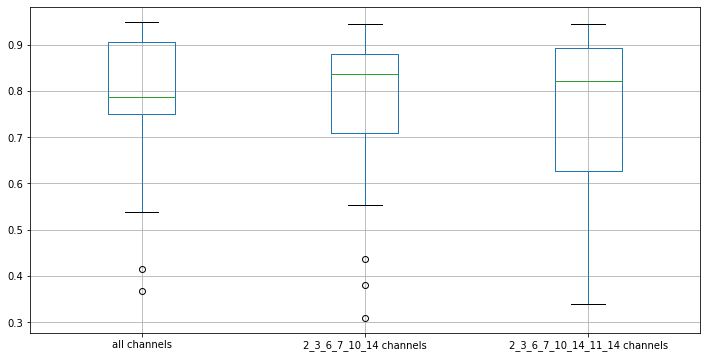

In [5]:
one_vs_all_df[one_vs_all_df.columns[1:]].boxplot(figsize=(12, 6))
one_vs_all_df[one_vs_all_df.columns[1:]].describe()

## Descrição excluindo os dois piores chb

,all channels,2_3_6_7_10_14 channels,2_3_6_7_10_14_11_14 channels
count,19.000000,19.000000,19.000000
mean,0.806662,0.797331,0.800450
std,0.128099,0.138131,0.134615
min,0.538462,0.435897,0.493590
25%,0.762054,0.736626,0.753199
50%,0.801075,0.863095,0.836250
75%,0.905485,0.888435,0.900888
max,0.950000,0.943750,0.944444


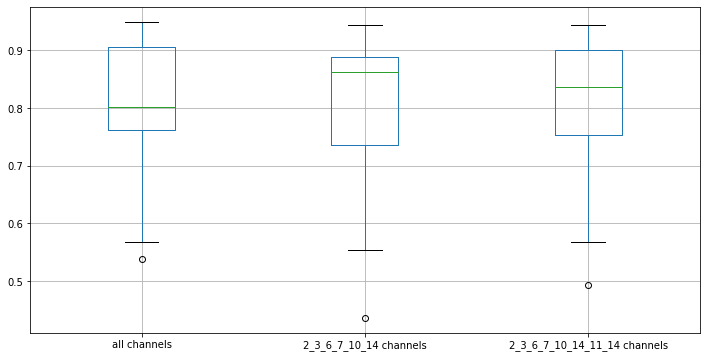

In [6]:
one_vs_all_df.sort_values(by='all channels', ascending=False).head(19)[one_vs_all_df.columns[1:]].boxplot(figsize=(12, 6))
one_vs_all_df.sort_values(by='all channels', ascending=False).head(19)[one_vs_all_df.columns[1:]].describe()

# Observando margem de probabilidade para todos os canais de cada CHB

margem de probabilidade para todos os canais do CHB 01
       negative sample-negative proba  negative sample-positive proba  \
count                       216.00000                       216.00000   
mean                          0.82037                         0.17963   
std                           0.25943                         0.25943   
min                           0.00000                         0.00000   
25%                           0.80000                         0.00000   
50%                           1.00000                         0.00000   
75%                           1.00000                         0.20000   
max                           1.00000                         1.00000   

       positive sample-negative proba  positive sample-positive proba  
count                      216.000000                      216.000000  
mean                         0.099074                        0.900926  
std                          0.197659                        0.197659  

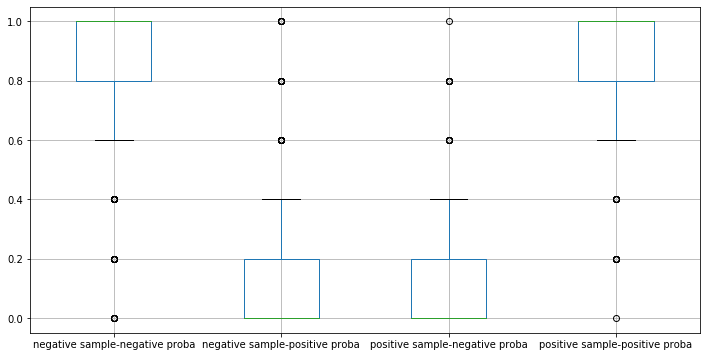

margem de probabilidade para todos os canais do CHB 02
       negative sample-negative proba  negative sample-positive proba  \
count                        84.00000                        84.00000   
mean                          0.92619                         0.07381   
std                           0.17775                         0.17775   
min                           0.20000                         0.00000   
25%                           1.00000                         0.00000   
50%                           1.00000                         0.00000   
75%                           1.00000                         0.00000   
max                           1.00000                         0.80000   

       positive sample-negative proba  positive sample-positive proba  
count                       84.000000                       84.000000  
mean                         0.416667                        0.583333  
std                          0.336113                        0.336113  

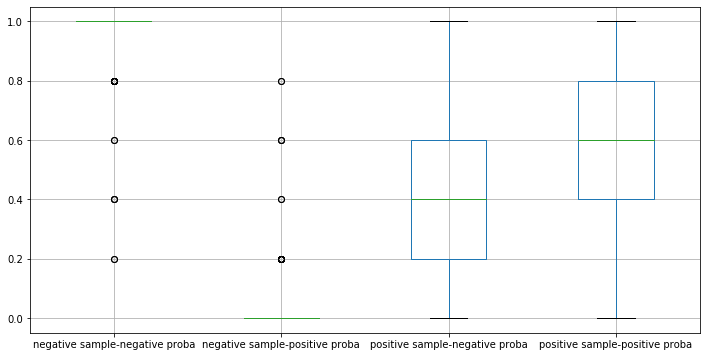

margem de probabilidade para todos os canais do CHB 03
       negative sample-negative proba  negative sample-positive proba  \
count                      196.000000                      196.000000   
mean                         0.903061                        0.096939   
std                          0.198948                        0.198948   
min                          0.000000                        0.000000   
25%                          0.800000                        0.000000   
50%                          1.000000                        0.000000   
75%                          1.000000                        0.200000   
max                          1.000000                        1.000000   

       positive sample-negative proba  positive sample-positive proba  
count                      196.000000                      196.000000  
mean                         0.146939                        0.853061  
std                          0.230141                        0.230141  

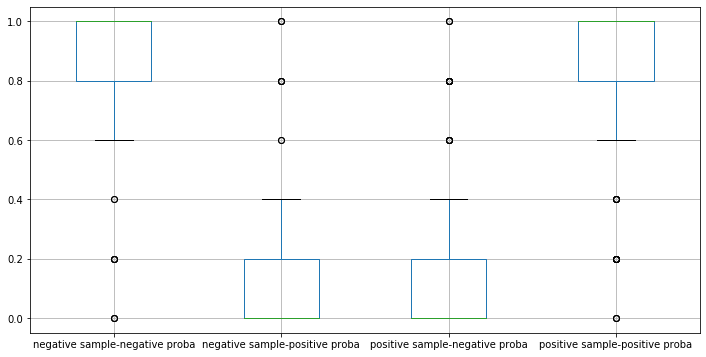

margem de probabilidade para todos os canais do CHB 04
       negative sample-negative proba  negative sample-positive proba  \
count                      186.000000                      186.000000   
mean                         0.884946                        0.115054   
std                          0.254451                        0.254451   
min                          0.000000                        0.000000   
25%                          0.850000                        0.000000   
50%                          1.000000                        0.000000   
75%                          1.000000                        0.150000   
max                          1.000000                        1.000000   

       positive sample-negative proba  positive sample-positive proba  
count                      186.000000                      186.000000  
mean                         0.300000                        0.700000  
std                          0.392497                        0.392497  

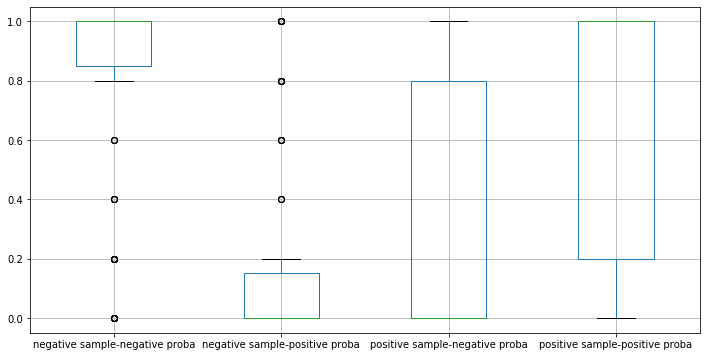

margem de probabilidade para todos os canais do CHB 05
       negative sample-negative proba  negative sample-positive proba  \
count                      275.000000                      275.000000   
mean                         0.778909                        0.221091   
std                          0.272844                        0.272844   
min                          0.000000                        0.000000   
25%                          0.600000                        0.000000   
50%                          0.800000                        0.200000   
75%                          1.000000                        0.400000   
max                          1.000000                        1.000000   

       positive sample-negative proba  positive sample-positive proba  
count                      275.000000                      275.000000  
mean                         0.101091                        0.898909  
std                          0.229484                        0.229484  

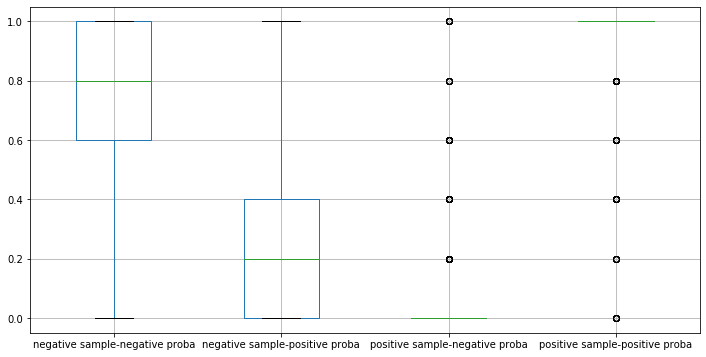

margem de probabilidade para todos os canais do CHB 07
       negative sample-negative proba  negative sample-positive proba  \
count                      160.000000                      160.000000   
mean                         0.873750                        0.126250   
std                          0.176082                        0.176082   
min                          0.200000                        0.000000   
25%                          0.800000                        0.000000   
50%                          1.000000                        0.000000   
75%                          1.000000                        0.200000   
max                          1.000000                        0.800000   

       positive sample-negative proba  positive sample-positive proba  
count                      160.000000                      160.000000  
mean                         0.070000                        0.930000  
std                          0.189272                        0.189272  

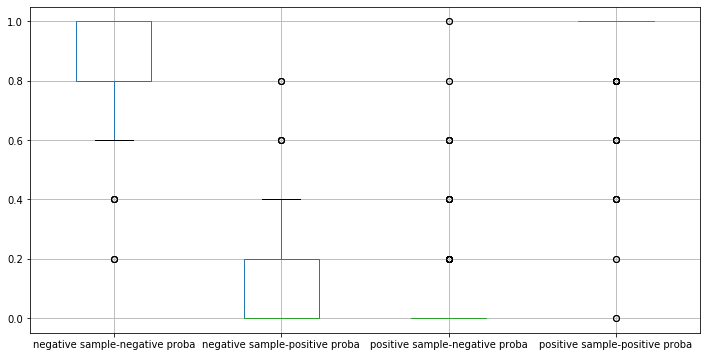

margem de probabilidade para todos os canais do CHB 08
       negative sample-negative proba  negative sample-positive proba  \
count                      455.000000                      455.000000   
mean                         0.758681                        0.241319   
std                          0.265917                        0.265917   
min                          0.000000                        0.000000   
25%                          0.600000                        0.000000   
50%                          0.800000                        0.200000   
75%                          1.000000                        0.400000   
max                          1.000000                        1.000000   

       positive sample-negative proba  positive sample-positive proba  
count                      455.000000                      455.000000  
mean                         0.314725                        0.685275  
std                          0.361017                        0.361017  

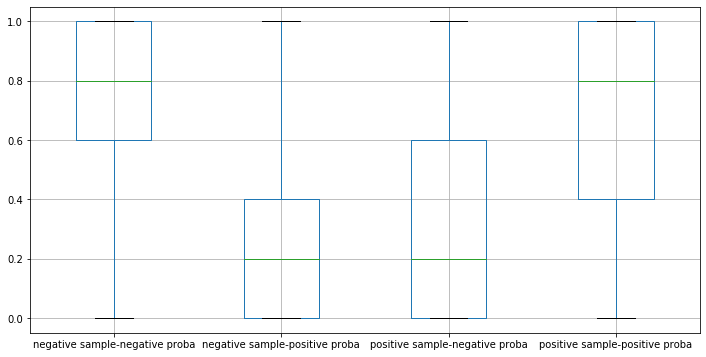

margem de probabilidade para todos os canais do CHB 10
       negative sample-negative proba  negative sample-positive proba  \
count                      218.000000                      218.000000   
mean                         0.834862                        0.165138   
std                          0.212675                        0.212675   
min                          0.000000                        0.000000   
25%                          0.800000                        0.000000   
50%                          0.900000                        0.100000   
75%                          1.000000                        0.200000   
max                          1.000000                        1.000000   

       positive sample-negative proba  positive sample-positive proba  
count                      218.000000                      218.000000  
mean                         0.138532                        0.861468  
std                          0.210511                        0.210511  

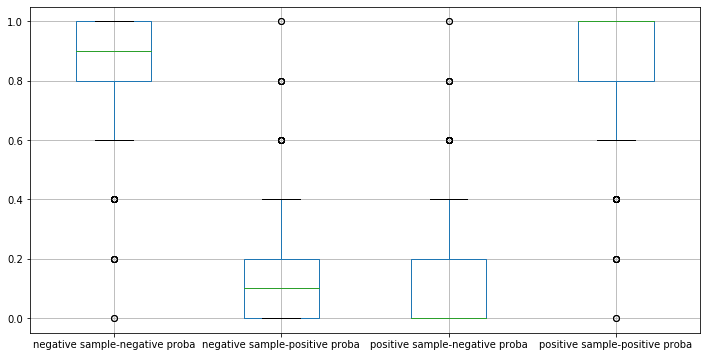

margem de probabilidade para todos os canais do CHB 11
       negative sample-negative proba  negative sample-positive proba  \
count                      400.000000                      400.000000   
mean                         0.783500                        0.216500   
std                          0.290928                        0.290928   
min                          0.000000                        0.000000   
25%                          0.600000                        0.000000   
50%                          1.000000                        0.000000   
75%                          1.000000                        0.400000   
max                          1.000000                        1.000000   

       positive sample-negative proba  positive sample-positive proba  
count                      400.000000                      400.000000  
mean                         0.372000                        0.628000  
std                          0.337195                        0.337195  

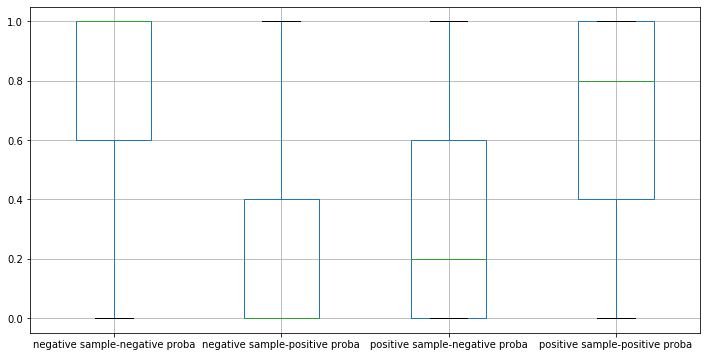

margem de probabilidade para todos os canais do CHB 12
       negative sample-negative proba  negative sample-positive proba  \
count                      476.000000                      476.000000   
mean                         0.914706                        0.085294   
std                          0.184088                        0.184088   
min                          0.000000                        0.000000   
25%                          0.800000                        0.000000   
50%                          1.000000                        0.000000   
75%                          1.000000                        0.200000   
max                          1.000000                        1.000000   

       positive sample-negative proba  positive sample-positive proba  
count                      476.000000                      476.000000  
mean                         0.726891                        0.273109  
std                          0.343406                        0.343406  

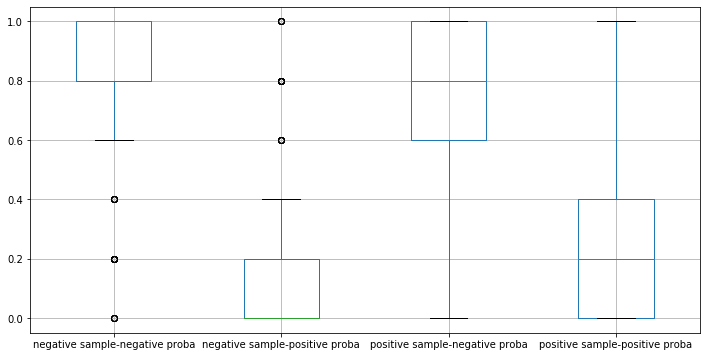

margem de probabilidade para todos os canais do CHB 13
       negative sample-negative proba  negative sample-positive proba  \
count                      258.000000                      258.000000   
mean                         0.845736                        0.154264   
std                          0.226462                        0.226462   
min                          0.000000                        0.000000   
25%                          0.800000                        0.000000   
50%                          1.000000                        0.000000   
75%                          1.000000                        0.200000   
max                          1.000000                        1.000000   

       positive sample-negative proba  positive sample-positive proba  
count                      258.000000                      258.000000  
mean                         0.693798                        0.306202  
std                          0.339432                        0.339432  

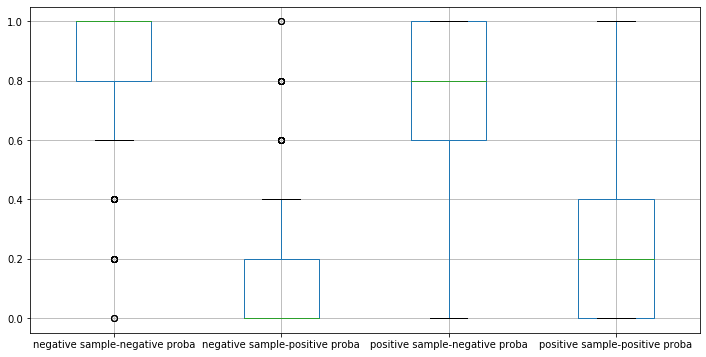

margem de probabilidade para todos os canais do CHB 14
       negative sample-negative proba  negative sample-positive proba  \
count                       78.000000                       78.000000   
mean                         0.858974                        0.141026   
std                          0.196354                        0.196354   
min                          0.200000                        0.000000   
25%                          0.800000                        0.000000   
50%                          1.000000                        0.000000   
75%                          1.000000                        0.200000   
max                          1.000000                        0.800000   

       positive sample-negative proba  positive sample-positive proba  
count                       78.000000                       78.000000  
mean                         0.823077                        0.176923  
std                          0.263800                        0.263800  

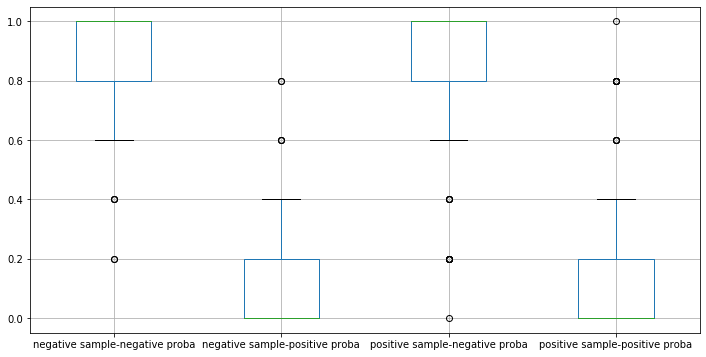

margem de probabilidade para todos os canais do CHB 15
       negative sample-negative proba  negative sample-positive proba  \
count                      112.000000                      112.000000   
mean                         0.419643                        0.580357   
std                          0.189755                        0.189755   
min                          0.000000                        0.200000   
25%                          0.400000                        0.400000   
50%                          0.400000                        0.600000   
75%                          0.600000                        0.600000   
max                          0.800000                        1.000000   

       positive sample-negative proba  positive sample-positive proba  
count                      112.000000                      112.000000  
mean                         0.444643                        0.555357  
std                          0.385045                        0.385045  

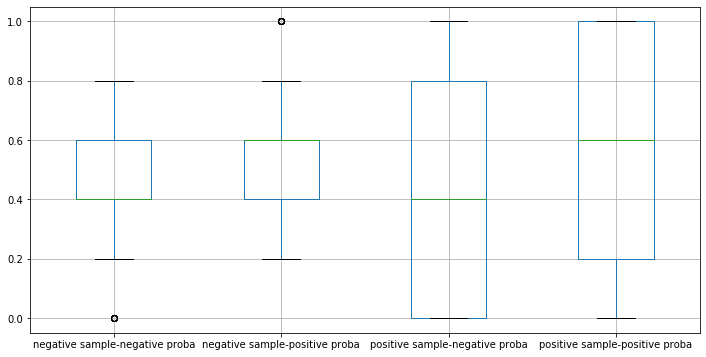

margem de probabilidade para todos os canais do CHB 16
       negative sample-negative proba  negative sample-positive proba  \
count                       34.000000                       34.000000   
mean                         0.423529                        0.576471   
std                          0.383808                        0.383808   
min                          0.000000                        0.000000   
25%                          0.000000                        0.200000   
50%                          0.400000                        0.600000   
75%                          0.800000                        1.000000   
max                          1.000000                        1.000000   

       positive sample-negative proba  positive sample-positive proba  
count                       34.000000                       34.000000  
mean                         0.658824                        0.341176  
std                          0.379886                        0.379886  

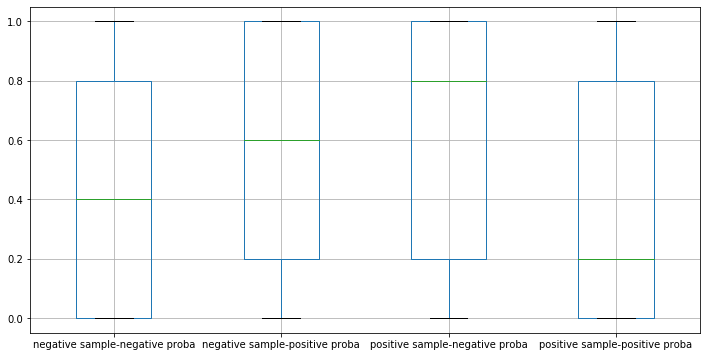

margem de probabilidade para todos os canais do CHB 17
       negative sample-negative proba  negative sample-positive proba  \
count                      144.000000                      144.000000   
mean                         0.811111                        0.188889   
std                          0.308189                        0.308189   
min                          0.000000                        0.000000   
25%                          0.800000                        0.000000   
50%                          1.000000                        0.000000   
75%                          1.000000                        0.200000   
max                          1.000000                        1.000000   

       positive sample-negative proba  positive sample-positive proba  
count                      144.000000                      144.000000  
mean                         0.354167                        0.645833  
std                          0.370763                        0.370763  

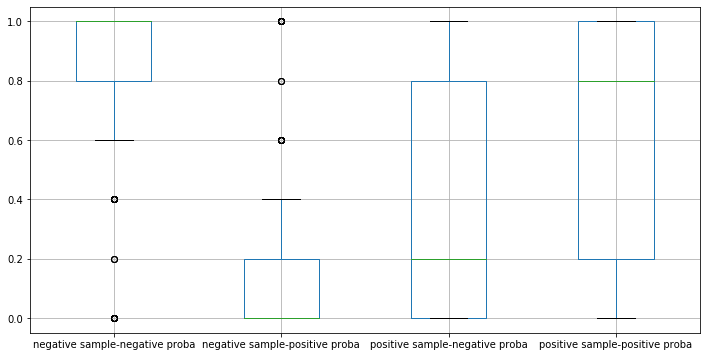

margem de probabilidade para todos os canais do CHB 18
       negative sample-negative proba  negative sample-positive proba  \
count                      153.000000                      153.000000   
mean                         0.942484                        0.057516   
std                          0.133127                        0.133127   
min                          0.000000                        0.000000   
25%                          1.000000                        0.000000   
50%                          1.000000                        0.000000   
75%                          1.000000                        0.000000   
max                          1.000000                        1.000000   

       positive sample-negative proba  positive sample-positive proba  
count                      153.000000                      153.000000  
mean                         0.420915                        0.579085  
std                          0.409212                        0.409212  

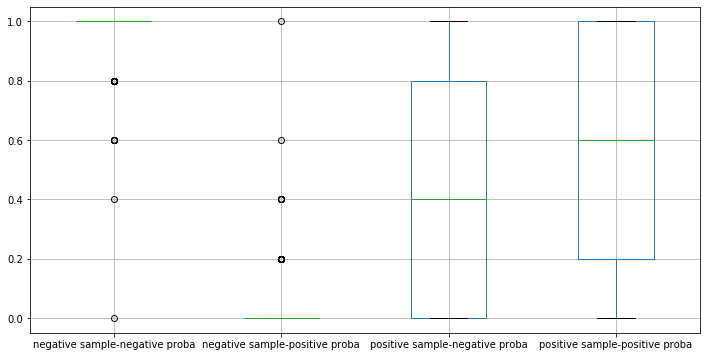

margem de probabilidade para todos os canais do CHB 19
       negative sample-negative proba  negative sample-positive proba  \
count                      116.000000                      116.000000   
mean                         0.906897                        0.093103   
std                          0.169769                        0.169769   
min                          0.200000                        0.000000   
25%                          0.800000                        0.000000   
50%                          1.000000                        0.000000   
75%                          1.000000                        0.200000   
max                          1.000000                        0.800000   

       positive sample-negative proba  positive sample-positive proba  
count                      116.000000                      116.000000  
mean                         0.174138                        0.825862  
std                          0.323600                        0.323600  

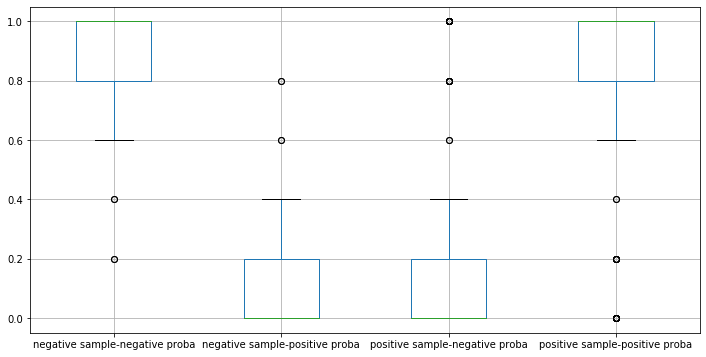

margem de probabilidade para todos os canais do CHB 21
       negative sample-negative proba  negative sample-positive proba  \
count                       96.000000                       96.000000   
mean                         0.914583                        0.085417   
std                          0.141406                        0.141406   
min                          0.400000                        0.000000   
25%                          0.800000                        0.000000   
50%                          1.000000                        0.000000   
75%                          1.000000                        0.200000   
max                          1.000000                        0.600000   

       positive sample-negative proba  positive sample-positive proba  
count                       96.000000                       96.000000  
mean                         0.454167                        0.545833  
std                          0.375546                        0.375546  

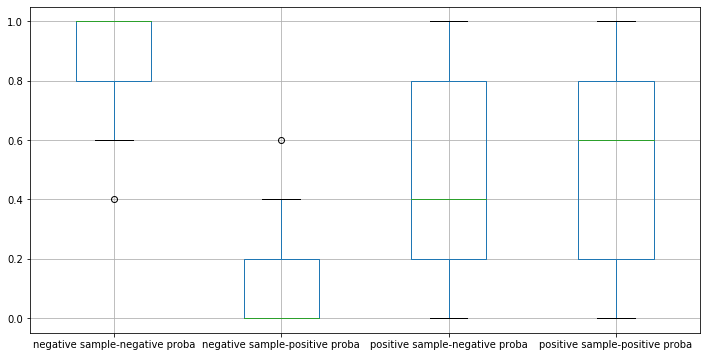

margem de probabilidade para todos os canais do CHB 22
       negative sample-negative proba  negative sample-positive proba  \
count                       99.000000                       99.000000   
mean                         0.935354                        0.064646   
std                          0.163703                        0.163703   
min                          0.200000                        0.000000   
25%                          1.000000                        0.000000   
50%                          1.000000                        0.000000   
75%                          1.000000                        0.000000   
max                          1.000000                        0.800000   

       positive sample-negative proba  positive sample-positive proba  
count                       99.000000                       99.000000  
mean                         0.103030                        0.896970  
std                          0.200741                        0.200741  

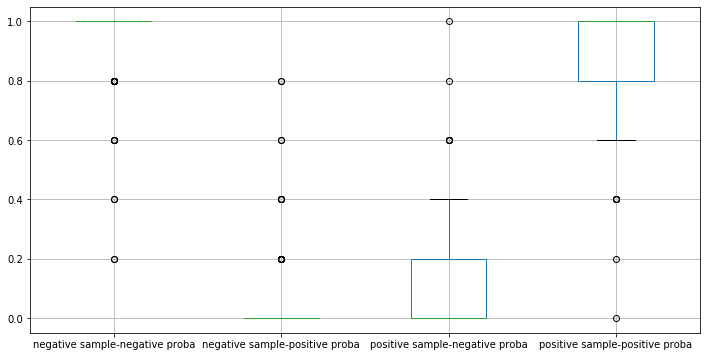

margem de probabilidade para todos os canais do CHB 23
       negative sample-negative proba  negative sample-positive proba  \
count                      207.000000                      207.000000   
mean                         0.892754                        0.107246   
std                          0.189777                        0.189777   
min                          0.000000                        0.000000   
25%                          0.800000                        0.000000   
50%                          1.000000                        0.000000   
75%                          1.000000                        0.200000   
max                          1.000000                        1.000000   

       positive sample-negative proba  positive sample-positive proba  
count                      207.000000                      207.000000  
mean                         0.200000                        0.800000  
std                          0.253136                        0.253136  

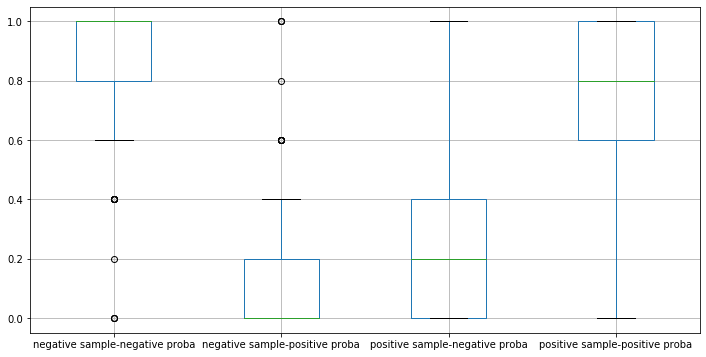

margem de probabilidade para todos os canais do CHB 24
       negative sample-negative proba  negative sample-positive proba  \
count                      244.000000                      244.000000   
mean                         0.910656                        0.089344   
std                          0.149791                        0.149791   
min                          0.200000                        0.000000   
25%                          0.800000                        0.000000   
50%                          1.000000                        0.000000   
75%                          1.000000                        0.200000   
max                          1.000000                        0.800000   

       positive sample-negative proba  positive sample-positive proba  
count                      244.000000                      244.000000  
mean                         0.245902                        0.754098  
std                          0.382573                        0.382573  

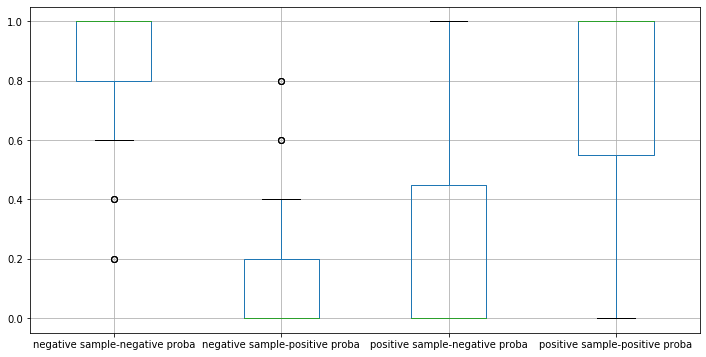

In [9]:
for chb in file_range:
    proba_df = proba_dict[chb]['all']
    
    print(f'margem de probabilidade para todos os canais do CHB {chb}')
    print(proba_df.describe())
    
    proba_df.boxplot(figsize=(12, 6))
    plt.show()